In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from fitter import Fitter
import random
import dill

In [2]:
geburtenRate = dill.load(open('../Daten/zf_geburtenrate/distributions_nach_sprache.pick', 'rb'))
todesRaten = dill.load(open('../Daten/zf_todesrate/distributions_nach_sprache.pick', 'rb'))
einwanderung = dill.load(open('../Daten/zf_einwanderung/distributions_nach_sprache.pick', 'rb'))
auswanderung = dill.load(open('../Daten/zf_auswanderung/distributions_nach_sprache.pick', 'rb'))

print(geburtenRate)

def generateDistribution(distr_type_params,n=10000):
    key = list(distr_type_params.keys())[0]
    params = distr_type_params[key]
    obj = getattr(stats, key)
   
    if type(params) is dict:
        params = list(params.values())

    dist_vals = obj.rvs(size=n,*params)
 
    return dist_vals

distirbutionDict = {}

for sprache in list(geburtenRate.keys()):
    lang_dict = distirbutionDict.get(sprache, {})

    lang_dict["birth"] = generateDistribution(geburtenRate[sprache])
    lang_dict["death"] = generateDistribution(todesRaten[sprache])
    lang_dict["einwanderung"] = generateDistribution(einwanderung[sprache])
    lang_dict["auswanderung"] = generateDistribution(auswanderung[sprache])
    lang_dict["zufallsFaktor"] = generateDistribution({"norm":{"loc": 1, "alpha":1}})


    distirbutionDict[sprache] = lang_dict

print(distirbutionDict)

{'Deutsch': {'alpha': (6.649188714144751, 20175.01379920206, 143276.68005196238)}, 'Französisch': {'alpha': (19.73994047941856, -14083.802839582937, 569507.7133426496)}, 'Italienisch': {'alpha': (6.608179899922543, 2550.7374245345563, 16737.048844317964)}, 'Andere': {'alpha': (6.882120127345814, 7862.990916467028, 62489.055734585214)}}
{'Deutsch': {'birth': array([38353.0696297 , 55513.3678312 , 39120.39786237, ...,
       43370.46238732, 41641.73359622, 41870.24200125]), 'death': array([32073.6158962 , 34002.38578659, 31330.21709947, ...,
       30954.95362275, 31697.75566037, 33225.3644226 ]), 'einwanderung': array([62096.88575839, 36490.62666103, 68288.5492825 , ...,
       30625.36441679, 38812.99533917, 59119.87903394]), 'auswanderung': array([43999.97315954, 34658.26834917, 51255.63345591, ...,
       35583.01029445, 39369.19880082, 44587.99372322]), 'zufallsFaktor': array([-0.98187669,  0.75592596,  1.74961821, ...,  1.77927056,
        0.59110177,  0.8337376 ])}, 'Französisch':

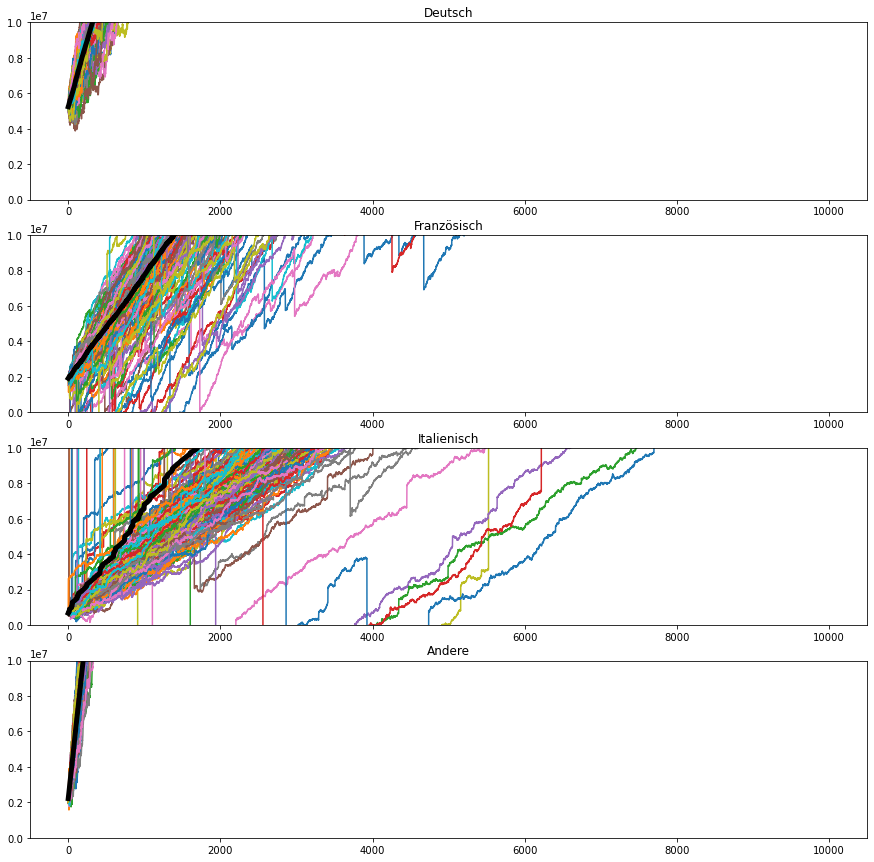

In [3]:
startValue = 7000000

def simulation(distirbutionDict,startValue,years=50,n=10):
    runs = []
    for i in range(n):
        valuesYear = [startValue]
        for year in range(2022,2022+years):
            temp = random.choice(distirbutionDict["zufallsFaktor"]) * random.choice(distirbutionDict["birth"]) - random.choice(distirbutionDict["zufallsFaktor"]) * random.choice(distirbutionDict["death"]) + random.choice(distirbutionDict["zufallsFaktor"]) * random.choice(distirbutionDict["einwanderung"]) - random.choice(distirbutionDict["zufallsFaktor"]) * random.choice(distirbutionDict["auswanderung"])
            newValue = valuesYear[-1] + temp
            valuesYear.append(newValue)
        runs.append(np.array(valuesYear))

    return np.array(runs)

def MeanOfSim(runs:np.array):
    return runs.mean(axis=0)

n = 200
years=10000
Deutsch = simulation(distirbutionDict["Deutsch"],5243758,years=years,n=n)
Französisch = simulation(distirbutionDict["Französisch"],1922946,years=years,n=n)
Italienisch = simulation(distirbutionDict["Italienisch"],669870,years=years,n=n)
Andere = simulation(distirbutionDict["Andere"],2214643,years=years,n=n)

fig, ax = plt.subplots(4, 1, figsize=(15,15))

#plot Deutsch
for i in range(len(Deutsch)):
    ax[0].plot(Deutsch[i])

ax[0].plot(MeanOfSim(Deutsch), color="black", linewidth=5)

ax[0].set_ylim([0, 10000000])
ax[0].set_title("Deutsch")

for i in range(len(Französisch)):
    ax[1].plot(Französisch[i])

ax[1].plot(MeanOfSim(Französisch), color="black", linewidth=5)

ax[1].set_ylim([0, 10000000])
ax[1].set_title("Französisch")

for i in range(len(Italienisch)):
    ax[2].plot(Italienisch[i])

ax[2].plot(MeanOfSim(Italienisch), color="black", linewidth=5)

ax[2].set_ylim([0, 10000000])
ax[2].set_title("Italienisch")

for i in range(len(Andere)):
    ax[3].plot(Andere[i])

ax[3].plot(MeanOfSim(Andere), color="black", linewidth=5)

ax[3].set_ylim([0, 10000000])
ax[3].set_title("Andere")

plt.show()

In [4]:
#plot stacked area chart of all languages with plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Deutsch),stackgroup='one',mode='lines', name='Deutsch',groupnorm='percent'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Französisch),stackgroup='one',mode='lines', name='Französisch'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Italienisch),stackgroup='one',mode='lines', name='Italienisch'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Andere),stackgroup='one',mode='lines', name='Andere'))


fig.update_layout(
    showlegend=True,
    xaxis_type='linear',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()


ModuleNotFoundError: No module named 'plotly'